In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# --- Step 1: Load the Data ---
file_name = 'MedicarePrescribers_by_Provider_2023.csv'
try:
    # We use low_memory=False to help with mixed data types in large files
    df = pd.read_csv(file_name, low_memory=False)
    print(f"Successfully loaded {file_name}")
    print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.")
except FileNotFoundError:
    print(f"Error: Make sure '{file_name}' is in the same folder as your script.")
    # In a notebook, we don't need exit(), an error is enough

Successfully loaded MedicarePrescribers_by_Provider_2023.csv
The dataset has 1380665 rows and 84 columns.


In [3]:
# --- Step 2: Data Cleaning and Preprocessing ---

# Standardize column names to snake_case for easier access
df.columns = df.columns.str.lower().str.replace(' ', '_')
print("Standardized column names.")

# Define the core columns we need for our analysis
# It's better to be explicit than to guess column names dynamically
numeric_cols = [
    'tot_clms',
    'tot_drug_cst',
    'tot_benes',
    'bene_avg_risk_scre',
    'opioid_tot_clms',
    'brnd_tot_clms'
]

# Convert these specific columns to numeric types.
# 'coerce' will turn any non-numeric values (like '*') into NaN (Not a Number)
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
print(f"Converted {len(numeric_cols)} key columns to numeric types.")

# Handle missing values by dropping rows where our essential columns are empty
df.dropna(subset=['tot_clms', 'tot_drug_cst', 'tot_benes'], inplace=True)
print(f"Removed rows with missing essential data. New shape: {df.shape}")

# --- Verification Step ---
print("\n--- Cleaned Data Overview ---")
# Display the first few rows to confirm changes
print(df.head())
# Display info to see new shape and data types
df.info()

Standardized column names.
Converted 6 key columns to numeric types.
Removed rows with missing essential data. New shape: (1237260, 84)

--- Cleaned Data Overview ---
   prscrbr_npi prscrbr_last_org_name prscrbr_first_name prscrbr_mi  \
0   1003000126             Enkeshafi            Ardalan        NaN   
1   1003000142                Khalil             Rashid        NaN   
2   1003000167               Escobar              Julio          E   
3   1003000423               Velotta           Jennifer          A   
4   1003000480             Rothchild              Kevin          B   

  prscrbr_crdntls prscrbr_ent_cd                 prscrbr_st1 prscrbr_st2  \
0            M.D.              I   6410 Rockledge Dr Ste 304         NaN   
1            M.D.              I  4126 N Holland Sylvania Rd   Suite 220   
2             DDS              I              5 Pine Cone Rd         NaN   
3            M.D.              I            11100 Euclid Ave         NaN   
4              MD              I

In [5]:
# --- Step 3: Feature Engineering ---

# To avoid division by zero, we'll use a small number where denominators are 0
# However, the dropna() in the previous cell should have already removed these.

# 1. Claims per Beneficiary
df['claims_per_beneficiary'] = df['tot_clms'] / df['tot_benes']

# 2. Cost per Claim
df['cost_per_claim'] = df['tot_drug_cst'] / df['tot_clms']

# 3. Opioid Claim Rate (fill missing opioid data with 0 first)
df['opioid_tot_clms'].fillna(0, inplace=True)
df['opioid_claim_rate'] = df['opioid_tot_clms'] / df['tot_clms']

# (in your feature engineering cell)

# 4. Opioid Prescription Rate
# First, fill missing opioid claims with 0 (a missing value here means they prescribed none)
df['opioid_tot_clms'] = df['opioid_tot_clms'].fillna(0) # Safer syntax
df['opioid_claim_rate'] = df['opioid_tot_clms'] / df['tot_clms']

# 5. Brand Name Drug Rate
df['brnd_tot_clms'] = df['brnd_tot_clms'].fillna(0) # Safer syntax
df['brand_claim_rate'] = df['brnd_tot_clms'] / df['tot_clms']

# --- Verification Step ---
feature_columns = [
    'prscrbr_npi', 'claims_per_beneficiary', 'cost_per_claim',
    'opioid_claim_rate', 'brand_claim_rate'
]
print("Successfully created new features. Here's a sample:")
print(df[feature_columns].head())
print("\nStatistical summary of new features:")
print(df[feature_columns].describe())

/var/folders/13/mmwbgpcx6dx13j0syfjl2h440000gn/T/ipykernel_7405/3309972573.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['opioid_tot_clms'].fillna(0, inplace=True)


Successfully created new features. Here's a sample:
   prscrbr_npi  claims_per_beneficiary  cost_per_claim  opioid_claim_rate  \
0   1003000126                1.982143       82.882793           0.058559   
1   1003000142                3.901674       33.578231           0.455764   
2   1003000167                2.000000        3.870085           0.000000   
3   1003000423                2.531250      118.080432           0.000000   
4   1003000480                1.576923       31.116829           0.390244   

   brand_claim_rate  
0          0.000000  
1          0.029491  
2          0.000000  
3          0.104938  
4          0.000000  

Statistical summary of new features:
        prscrbr_npi  claims_per_beneficiary  cost_per_claim  \
count  1.237260e+06            1.237260e+06    1.237260e+06   
mean   1.499565e+09            5.252943e+00    1.814493e+02   
std    2.878956e+08            6.035413e+00    5.267806e+02   
min    1.003000e+09            1.000000e+00    4.550000e-01   


In [6]:
# --- Step 5: Anomaly Detection Modeling ---

# Select the features we engineered for the model
features_for_model = [
    'claims_per_beneficiary',
    'cost_per_claim',
    'opioid_claim_rate',
    'brand_claim_rate'
]

# Create a new DataFrame with just these features
model_df = df[features_for_model]

# 1. Scale the data
scaler = StandardScaler()
model_scaled = scaler.fit_transform(model_df)
print("Features scaled successfully.")

# 2. Run the Isolation Forest Model
# 'contamination' is the expected proportion of anomalies in the data.
# Let's assume the top 1% are potential outliers.
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
predictions = iso_forest.fit_predict(model_scaled)

# Add the predictions back to our main dataframe
# The model outputs -1 for anomalies and 1 for normal data points
df['is_anomaly'] = predictions
print("Anomaly detection complete.")

# 3. Analyze the results
# How many anomalies did we find?
anomaly_count = df['is_anomaly'].value_counts()
print("\nAnomaly detection results:")
print(anomaly_count)

# Create a dataframe of just the anomalous providers
anomalies = df[df['is_anomaly'] == -1]

print("\nStatistical summary of anomalous providers:")
print(anomalies[features_for_model].describe())

Features scaled successfully.
Anomaly detection complete.

Anomaly detection results:
is_anomaly
 1    1224887
-1      12373
Name: count, dtype: int64

Statistical summary of anomalous providers:
       claims_per_beneficiary  cost_per_claim  opioid_claim_rate  \
count            12373.000000    12373.000000       12373.000000   
mean                12.707724     3236.396228           0.161676   
std                 17.218638     3104.657111           0.255896   
min                  1.000000        4.273313           0.000000   
25%                  4.631579      392.605877           0.000000   
50%                  6.606557     3065.768032           0.039076   
75%                 11.493333     4581.615164           0.143161   
max                242.875000   107128.796066           1.000000   

       brand_claim_rate  
count      12373.000000  
mean           0.267740  
std            0.238646  
min            0.000000  
25%            0.036850  
50%            0.241403  
75%      

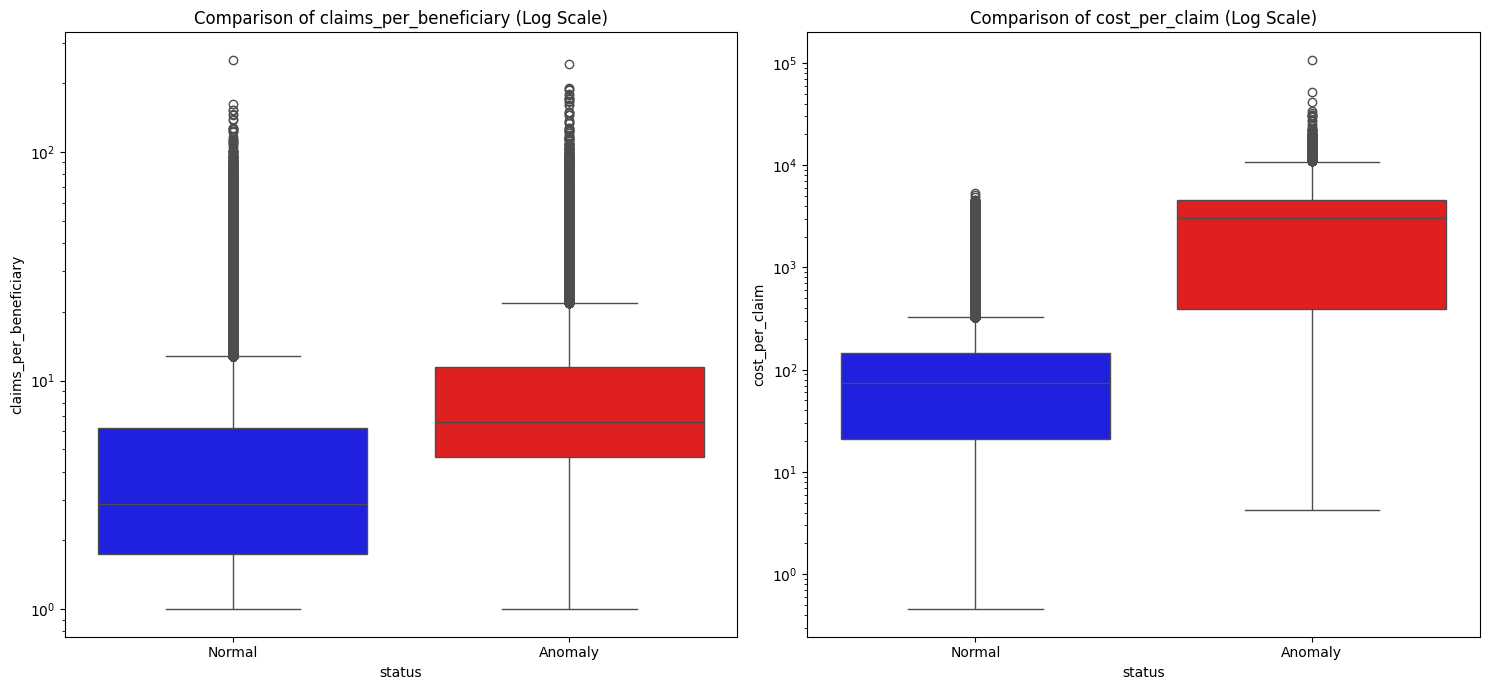

In [9]:
# --- Step 6: Final Visualization (Improved) ---
import seaborn as sns
import matplotlib.pyplot as plt

# Features to plot
features_to_plot = ['claims_per_beneficiary', 'cost_per_claim']
df['status'] = df['is_anomaly'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')

# Create side-by-side box plots
plt.figure(figsize=(15, 7))
for i, feature in enumerate(features_to_plot):
    plt.subplot(1, 2, i+1)
    
    # Updated code to fix the warning
    sns.boxplot(x='status', y=feature, data=df,
                hue='status', palette=['blue', 'red'], legend=False)
    
    plt.title(f'Comparison of {feature} (Log Scale)')
    
    # Use a logarithmic scale to better visualize the difference and outliers
    plt.yscale('log')

plt.tight_layout()
plt.savefig('boxplot_comparison_log_scale.png')
plt.show()

In [10]:
# --- Step 7: Final Persona Profiling and Conclusion ---

# Create two groups: 'Anomaly' and 'Normal'
df['status'] = df['is_anomaly'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')

# Create a summary table comparing the two groups
conclusion_table = df.groupby('status').agg(
    # --- Our Engineered Features ---
    avg_claims_per_beneficiary=('claims_per_beneficiary', 'mean'),
    avg_cost_per_claim=('cost_per_claim', 'mean'),
    avg_opioid_rate=('opioid_claim_rate', 'mean'),
    avg_brand_rate=('brand_claim_rate', 'mean'),
    
    # --- Key Patient Profile Metrics ---
    avg_patient_age=('bene_avg_age', 'mean'),
    avg_patient_risk_score=('bene_avg_risk_scre', 'mean'),
    
    # --- Dominant Provider Specialty ---
    most_common_specialty=('prscrbr_type', lambda x: x.mode()[0])
)

print("--- Final Comparison: Normal vs. Anomalous Providers ---")
print(conclusion_table.round(2).T) # .T transposes the table for easier reading

--- Final Comparison: Normal vs. Anomalous Providers ---
status                                  Anomaly              Normal
avg_claims_per_beneficiary                12.71                5.18
avg_cost_per_claim                       3236.4              150.59
avg_opioid_rate                            0.16                0.05
avg_brand_rate                             0.27                0.11
avg_patient_age                           69.43               70.96
avg_patient_risk_score                     2.21                1.55
most_common_specialty       Hematology-Oncology  Nurse Practitioner


In [12]:
# --- Step 8: The Investigation (Revised to show NPI) ---

# Create a DataFrame of just the anomalies for our investigation
anomalies_df = df[df['is_anomaly'] == -1].copy()

# --- Lead 1: Following the Money (The Most Extreme Spenders) ---
print("--- Lead 1: The Highest Cost Providers ---")
highest_cost_providers = anomalies_df.sort_values(by='cost_per_claim', ascending=False).head(10)
# ADDED 'prscrbr_npi' to the list of columns to display
print(highest_cost_providers[[
    'prscrbr_npi', 'prscrbr_last_org_name', 'prscrbr_first_name', 'prscrbr_type',
    'prscrbr_city', 'prscrbr_state_abrvtn', 'cost_per_claim'
]])

# --- Lead 2: Following the Contradiction (Healthy Patients, Expensive Drugs) ---
print("\n--- Lead 2: Suspicious Cases (Low-Risk Patients, High Costs) ---")
low_risk_threshold = anomalies_df['bene_avg_risk_scre'].quantile(0.25)
high_cost_threshold = anomalies_df['cost_per_claim'].quantile(0.75)

suspicious_cases = anomalies_df[
    (anomalies_df['bene_avg_risk_scre'] <= low_risk_threshold) &
    (anomalies_df['cost_per_claim'] >= high_cost_threshold)
].sort_values(by='cost_per_claim', ascending=False).head(10)

# ADDED 'prscrbr_npi' to the list of columns to display
print(suspicious_cases[[
    'prscrbr_npi', 'prscrbr_last_org_name', 'prscrbr_first_name', 'prscrbr_type',
    'prscrbr_city', 'prscrbr_state_abrvtn', 'cost_per_claim', 'bene_avg_risk_scre'
]])

# --- Lead 3: Following the Pattern (Geographic Hotspots) ---
print("\n--- Lead 3: Geographic Hotspots for Anomalies ---")
state_hotspots = anomalies_df['prscrbr_state_abrvtn'].value_counts().head(10)
print("\nTop 10 States:")
print(state_hotspots)

city_hotspots = anomalies_df['prscrbr_city'].value_counts().head(10)
print("\nTop 10 Cities:")
print(city_hotspots)

--- Lead 1: The Highest Cost Providers ---
         prscrbr_npi prscrbr_last_org_name prscrbr_first_name  \
1316140   1952420705                  Rush               Eric   
627188    1457439713                Taylor            Matthew   
632291    1457745341                 Knoll            Jasmine   
1150070   1831255777            Rubinstein               Arye   
1124677   1811371693                   Noh                Ada   
537600    1386866564           Smith-Hicks          Constance   
474211    1346324761                 Jones            Douglas   
938136    1679893010                Mcnutt             Markey   
14050     1013007780           Kirkpatrick            Charles   
384989    1275841603         Sanchez-Valle           Amarilis   

                          prscrbr_type prscrbr_city prscrbr_state_abrvtn  \
1316140              Internal Medicine  Kansas City                   MO   
627188   Medical Genetics and Genomics       Aurora                   CO   
632291   Medi

In [13]:
# --- Final Investigation: Opioid Outliers ---

# Focus on the 12,373 anomalous providers
anomalies_df = df[df['is_anomaly'] == -1].copy()

# Find the threshold for extreme opioid prescribers (e.g., the top 5% within the anomaly group)
opioid_threshold = anomalies_df['opioid_claim_rate'].quantile(0.95)

print(f"Identifying anomalous providers with an opioid claim rate in the top 5% (above {opioid_threshold:.2f})...")

# Filter for anomalies who are also extreme opioid prescribers
suspicious_opioid_prescribers = anomalies_df[
    anomalies_df['opioid_claim_rate'] >= opioid_threshold
].sort_values(by='opioid_claim_rate', ascending=False)

# Display the top 10 most suspicious opioid prescribers
print("\n--- Top 10 Most Suspicious Opioid Prescribers ---")
print(suspicious_opioid_prescribers[[
    'prscrbr_npi', 'prscrbr_last_org_name', 'prscrbr_first_name', 'prscrbr_type',
    'prscrbr_city', 'prscrbr_state_abrvtn', 'opioid_claim_rate', 'cost_per_claim'
]].head(10))

Identifying anomalous providers with an opioid claim rate in the top 5% (above 0.75)...

--- Top 10 Most Suspicious Opioid Prescribers ---
         prscrbr_npi prscrbr_last_org_name prscrbr_first_name  \
1106142   1801065198                Koduri            Hemanth   
643337    1467565986            Rosenfield           Laurence   
708916    1518195247               Keroles              Sadaf   
718771    1518975507                Khoury               Riad   
271033    1194740407                Schick              Laura   
169548    1124153754               Tisdall            William   
1169367   1841676830                Rajani            Sabeena   
1086121   1780694190                 Tafor              Donna   
91221     1063645950               Perkins                 Ty   
1150145   1831259803               Galphin             Robert   

                                 prscrbr_type      prscrbr_city  \
1106142  Physical Medicine and Rehabilitation            Edison   
643337     

In [14]:
# --- Final Check on Dr. Tafor's Volume ---

# Filter the original cleaned dataframe for Dr. Tafor's NPI
dr_tafor_data = df[df['prscrbr_npi'] == 1780694190]

# Extract the relevant values
total_claims = dr_tafor_data['tot_clms'].iloc[0]
opioid_claims = dr_tafor_data['opioid_tot_clms'].iloc[0]
total_patients = dr_tafor_data['tot_benes'].iloc[0]

print(f"--- Dr. Tafor (NPI 1780694190) Summary ---")
print(f"Total Medicare Part D Patients: {total_patients:.0f}")
print(f"Total Prescriptions (Claims): {total_claims:.0f}")
print(f"Total Opioid Prescriptions: {opioid_claims:.0f}")
print(f"Opioid Prescription Rate: {(opioid_claims / total_claims) * 100:.2f}%")

--- Dr. Tafor (NPI 1780694190) Summary ---
Total Medicare Part D Patients: 15
Total Prescriptions (Claims): 91
Total Opioid Prescriptions: 87
Opioid Prescription Rate: 95.60%
